In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

def load_pubmed_rct_file(filepath):
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})

class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])
            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)
            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]
                non_zero_indices = x_i.indices
                non_zero_data = x_i.data
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)
        return np.array(y_pred)

train_df = load_pubmed_rct_file("/content/train.txt")
dev_df = load_pubmed_rct_file("/content/dev.txt")
test_df = load_pubmed_rct_file("/content/test.txt")


In [5]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [6]:
if X_train is not None and len(X_train) > 0:

    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1,2),
        min_df=2
    )

    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)

    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)

    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [7]:
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825



=== Confusion Matrix (Custom Count-Based Naive Bayes) ===


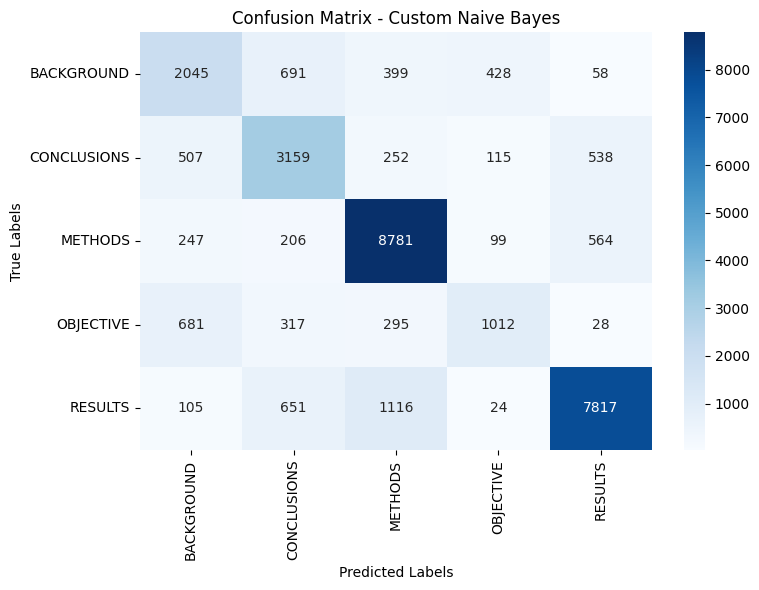

In [8]:
# Confusion Matrix on test set
print("\n=== Confusion Matrix (Custom Count-Based Naive Bayes) ===")

if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=nb_model.classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=nb_model.classes,
                yticklabels=nb_model.classes)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Custom Naive Bayes")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix cannot be generated because predictions are missing.")


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Train initial pipeline
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 5],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")


if grid is not None and hasattr(grid, 'best_params_'):
    print("\n=== Best Parameters Found ===")
    print(grid.best_params_)
    print(f"Best cross-validation F1_macro score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7266
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51      3621
 CONCLUSIONS       0.62      0.61      0.62      4571
     METHODS       0.72      0.90      0.80      9897
   OBJECTIVE       0.73      0.10      0.18      2333
     RESULTS       0.80      0.87      0.83      9713

    accuracy                           0.73     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.72      0.73      0.70     30135

Macro-averaged F1 score: 0.5877

Starting Hyperparameter Tuning on Development Set...
Grid search complete.

=== Best Parameters Found ===
{'nb__alpha': 0.1, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Best cross-validation F1_macro score: 0.6991



Training all base models...
Training NaiveBayes ...
Training LogisticRegression ...
Training RandomForest ...
Training DecisionTree ...
Training KNN ...
All base models trained.

Calculating posterior weights...
Re-training NaiveBayes ...
Re-training LogisticRegression ...
Re-training RandomForest ...
Re-training DecisionTree ...
Re-training KNN ...

Posterior weights:
NaiveBayes: 0.0000
LogisticRegression: 0.0000
RandomForest: 0.0000
DecisionTree: 0.0000
KNN: 1.0000

Fitting the VotingClassifier...
Fitting complete.

Predicting on test set...

=== FINAL EVALUATION ===
Accuracy: 0.36339804214368676


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  BACKGROUND       0.00      0.00      0.00      3621
 CONCLUSIONS       0.00      0.00      0.00      4571
     METHODS       0.37      0.63      0.47      9897
   OBJECTIVE       1.00      0.00      0.00      2333
     RESULTS       0.36      0.48      0.41      9713

    accuracy                           0.36     30135
   macro avg       0.35      0.22      0.18     30135
weighted avg       0.31      0.36      0.29     30135



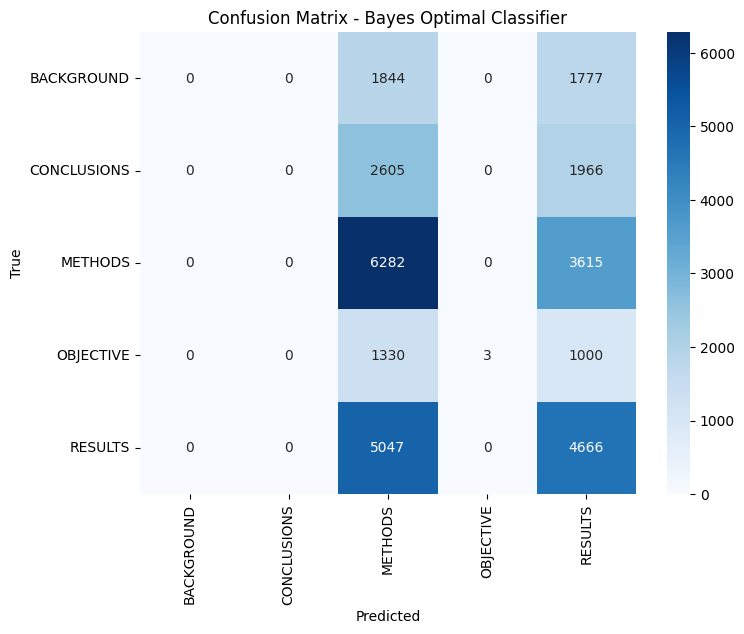

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

if 'X_train' not in globals():
    print("Warning: Using fallback data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

BASE_SAMPLE_SIZE = 10000
FULL_SRN = "PES1UG22CS000"     # <-- You can replace input with constant for testing

try:
    srn_suffix_str = FULL_SRN[-3:]
    srn_value = int(srn_suffix_str)
except:
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
effective_sample_size = min(SAMPLE_SIZE, len(X_train))

X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]

tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# H1 Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2 Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

# H3 Random Forest (calibrated)
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10), cv=3))
])

# H4 Decision Tree (calibrated)
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10), cv=3))
])

# H5 KNN (calibrated)
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(KNeighborsClassifier(n_neighbors=5), cv=3))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

print("\nTraining all base models...")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name} ...")
    model.fit(X_train_sampled, y_train_sampled)

print("All base models trained.")

print("\nCalculating posterior weights...")

X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

log_likelihoods = []

for name, model in zip(hypothesis_names, hypotheses):
    print(f"Re-training {name} ...")
    model.fit(X_subtrain, y_subtrain)

    probs = model.predict_proba(X_val)

    eps = 1e-12
    y_idx = y_val.factorize()[0]
    ll = np.sum(np.log(probs[np.arange(len(y_val)), y_idx] + eps))
    log_likelihoods.append(ll)

# Normalize
posterior_weights = np.exp(log_likelihoods - np.max(log_likelihoods))
posterior_weights /= posterior_weights.sum()

print("\nPosterior weights:")
for name, w in zip(hypothesis_names, posterior_weights):
    print(f"{name}: {w:.4f}")

print("\nFitting the VotingClassifier...")

estimators = list(zip(hypothesis_names, hypotheses))

boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights
)

boc_soft_voter.fit(X_train_sampled, y_train_sampled)

print("Fitting complete.")
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)
print("\n=== FINAL EVALUATION ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Bayes Optimal Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
